In [90]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import eig

Converged epsilon_n for mode 1: 0.9997357911430298
Converged epsilon_n for mode 2: 2.9990026018582294
Converged epsilon_n for mode 3: 4.998463054653261
Converged epsilon_n for mode 4: 6.997581001278018
Converged epsilon_n for mode 5: 8.996254249569033


(array([[2.56023908e-04, 1.45261190e-03, 5.65783873e-03, 1.74247033e-02,
         4.49716541e-02],
        [3.76704668e-04, 2.08090003e-03, 7.87406355e-03, 2.34942195e-02,
         5.85268010e-02],
        [5.51333049e-04, 2.96477386e-03, 1.08973736e-02, 3.14957084e-02,
         7.57119110e-02],
        [8.00736395e-04, 4.19027275e-03, 1.49549870e-02, 4.18498818e-02,
         9.70292818e-02],
        [1.15230933e-03, 5.86545728e-03, 2.03156030e-02, 5.50069969e-02,
         1.22892293e-01],
        [1.64247145e-03, 8.12654770e-03, 2.72920161e-02, 7.14286433e-02,
         1.53600245e-01],
        [2.31906176e-03, 1.11444492e-02, 3.62571649e-02, 9.16072529e-02,
         1.89280537e-01],
        [3.24162496e-03, 1.51206884e-02, 4.76086454e-02, 1.15975906e-01,
         2.29811529e-01],
        [4.48522818e-03, 2.02874785e-02, 6.17600351e-02, 1.44840204e-01,
         2.74657391e-01],
        [6.14601739e-03, 2.69273187e-02, 7.91314209e-02, 1.78373546e-01,
         3.22845862e-01],
        [8

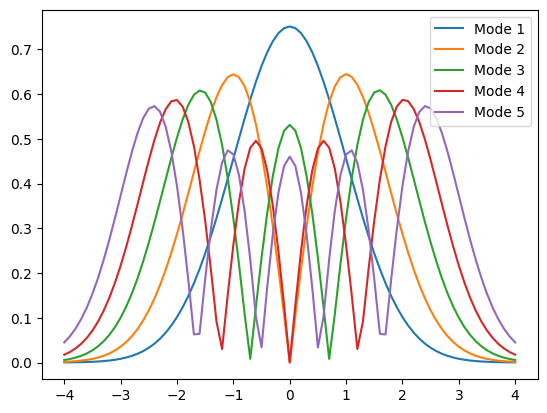

In [91]:
def bvp(x, y, k, epsilon_n):
    return [y[1], (k * (x**2) - epsilon_n) * y[0]]

L = 4
K = 1
x_span = np.arange(-L,L+0.1,0.1)
t_eval = np.linspace(-L, L, 81)
epsilon_n = 0.1
tol = 1e-4
A1 = []
A2 = []

for mode in range(1, 6):
    # epsilon_n = epsilon_start
    #y0 = [1, np.sqrt(L**2 - epsilon_n)]
    depsilon = 0.2

    for _ in range(1000):
        y0 = [1, np.sqrt(L**2 - epsilon_n)]
        sol = solve_ivp(lambda x_span, y: bvp(x_span, y, K, epsilon_n),  [x_span[0],x_span[-1]], y0, t_eval=x_span)

        temp = sol.y.T[-1,1] + np.sqrt(L**2 - epsilon_n) * sol.y.T[-1,0]

        if abs(temp) < tol:
            print(f"Converged epsilon_n for mode {mode}: {epsilon_n}")
            A2.append(epsilon_n)
            break

        if (-1)**(mode + 1) * temp > 0:
            epsilon_n += depsilon
        else:
            epsilon_n -= depsilon / 2
            depsilon /= 2

    epsilon_n += 0.2

    norm = sol.y[0] / np.sqrt(np.trapz(sol.y[0]**2, sol.t))
    A1.append(norm)

    plt.plot(sol.t, np.abs(norm), label=f'Mode {mode}')

plt.legend()


A1 = np.column_stack([np.abs(ef) for ef in A1])
A2 = np.array(A2)
A1, A2

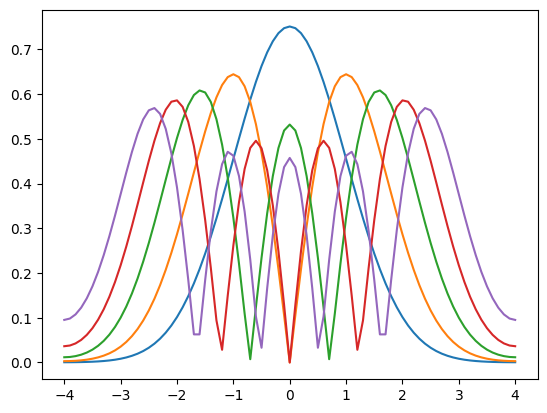

In [92]:
xspan = np.arange(-4, 4 + 0.1, 0.1)
dx = xspan[1] - xspan[0]
len_xspan = len(xspan)
N = 79
L = 4

B = np.zeros((N,N))
B[0,0] = 2/3 + dx ** 2 * xspan[1] ** 2
B[0,1] = -2/3
B[78,78] = 2/3 + dx ** 2 * xspan[len_xspan - 2] ** 2
B[78,77] = -2/3

for i in range(1, N-1):
    B[i,i-1] = -1
    B[i, i] = 2 + dx ** 2 * xspan[i + 1] ** 2
    B[i,i+1] = -1

D,V = eig(B)
eig_val = D.real
indices = np.argsort(eig_val / dx ** 2)
eig_val = np.sort(eig_val / dx ** 2)[:5]

eig_vec = []
for i in range (5):
    temp = V[:,indices[i]].real
    vec = np.concatenate((
        [(4 * temp[0]- temp[1]) / 3],
        temp,
        [(4 * temp[78]- temp[77]) / 3]
    ))
    eig_vec.append(vec)

eig_vec = np.array(eig_vec).T
for i in range(eig_vec.shape[1]):
    eig_vec[:, i] = np.abs(eig_vec[:, i] / np.sqrt(np.trapz(eig_vec[:, i] ** 2, xspan)))

plt.plot(xspan, eig_vec)

A3 = eig_vec
A4 = eig_val

array([1.01386719, 2.92260742])

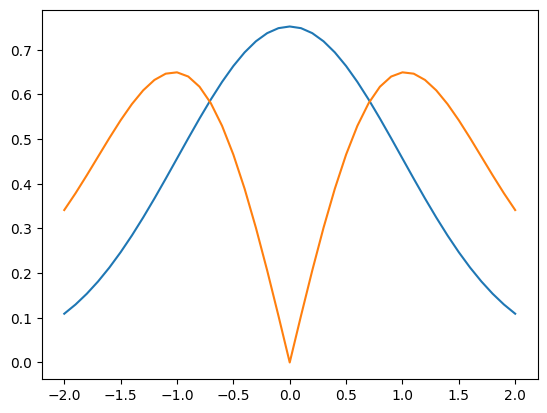

In [93]:
def bvp_nonlinear(y, x, k, gamma, epsilon_n):
    return [y[1], (gamma * np.abs(y[0]) ** 2 + k * (x**2) - epsilon_n) * y[0]]

L = 2
K = 1
xspan = np.arange(-L, L + 0.1, 0.1)
epsilon_initial_start = 0.2
tol = 1e-4
initial_A = 0.1

A5 = []
A6 = []
A7 = []
A8 = []

for gamma in [0.05, -0.05]:
    epsilon_start = epsilon_initial_start
    A = initial_A
    for mode in range(1, 3):

        epsilon_n = epsilon_start
        depsilon = 0.1
        found_solution = False

        for _ in range(1000):
            y0 = [A, A * np.sqrt(L**2 - epsilon_n)]
            y = odeint(bvp_nonlinear, y0, xspan, args = (K, gamma, epsilon_n))

            ynorm = np.trapz(y[:, 0]**2, xspan)

            if abs(ynorm - 1) < tol:
                found_solution = True
                break
            else:
                A /= np.sqrt(ynorm)

            temp = y[-1, 1] + np.sqrt(L**2 - epsilon_n) * y[-1, 0]

            if abs(temp) < tol:
                found_solution = True
                break

            if (-1)**(mode + 1) * temp > 0:
                epsilon_n += depsilon
            else:
                epsilon_n -= depsilon / 2
                depsilon /= 2

        if found_solution:
            if gamma == 0.05:
                    A5.append(y[:,0])
                    A6.append(epsilon_n)
            elif gamma == -0.05:
                    A7.append(y[:,0])
                    A8.append(epsilon_n)
        epsilon_start = epsilon_n + 0.2

plt.plot(xspan, np.abs(np.array(A7).T))
A5 = np.abs(A5).T
A6 = np.array(A6)
A7 = np.abs(A7).T
A8 = np.array(A8)
A5, A6, A7, A8
A6

(4,)

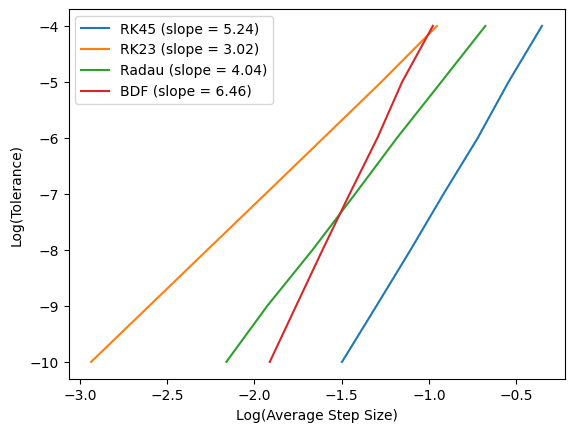

In [94]:
epsilon_n = 1
gamma = 0
L = 2
K = 1
xspan = [-L, L]
TOL = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
methods = ['RK45', 'RK23', 'Radau', 'BDF']

A9 = []

def bvp_nonlinear(x, y, k, gamma, epsilon_n):
    return [y[1], (gamma * np.abs(y[0]) ** 2 + k * (x**2) - epsilon_n) * y[0]]

y0 = [1, np.sqrt(K * L**2 - epsilon_n)]

for method in methods:
    avg_step_sizes = []
    for tol in TOL:
        options = {'rtol': tol, 'atol': tol}
        y = solve_ivp(bvp_nonlinear, xspan, y0, method=method, args=(K, gamma, epsilon_n), **options)

        avg_step_sizes.append(np.mean(np.diff(y.t)))

    log_tol = np.log10(TOL)
    log_avg_step_sizes = np.log10(avg_step_sizes)

    slope, _ = np.polyfit(log_avg_step_sizes, log_tol, 1)
    A9.append(slope)


    plt.plot(log_avg_step_sizes, log_tol, label=f"{method} (slope = {slope:.2f})")

plt.xlabel("Log(Average Step Size)")
plt.ylabel("Log(Tolerance)")
plt.legend()

A9 = np.array(A9).reshape(4, 1)
A9 = A9.reshape(4,)
A9.shape

In [95]:
exact_eig = [1,3,5,7,9]
L = 4
xspan = np.linspace(-L, L, 81)

h = np.array([np.ones_like(xspan), 
                2*xspan,
                4*xspan**2-2,
                8 * xspan**3 - 12*xspan,
                16*xspan**4 - 48 * xspan**2 +12])

def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

phi = np.zeros((81, 5))
for j in range(5):
    phi[:,j] = (h[j,:]*np.exp(-xspan**2 / 2)/np.sqrt(2**j * factorial(j) * np.sqrt(np.pi))).T

A10 = np.zeros(5)
A11 = np.zeros(5)
A12 = np.zeros(5)
A13 = np.zeros(5)

for i in range(5):
    A10[i] = np.trapz((np.abs(A1[:,i]) - np.abs(phi[:,i]))**2, xspan)
    A11[i] = 100 * (np.abs(A2[i] - 2 * (i+1) + 1)/(2 * (i+1) - 1))
    A12[i] = np.trapz((np.abs(A3[:,i]) - np.abs(phi[:,i]))**2, xspan)
    A13[i] = 100 * (np.abs(A4[i] - 2 * (i+1) + 1)/(2 * (i+1) - 1))

print(A12)
print(A13)
print(A10)
print(A11)


[2.33908579e-07 2.39720320e-06 1.81275996e-05 1.53048072e-04
 1.24238600e-03]
[0.0626477  0.10536673 0.1718688  0.28016214 0.54888859]
[4.57692814e-08 1.72430946e-07 2.47861359e-07 4.35421341e-07
 1.96490935e-06]
[0.02642089 0.0332466  0.03073891 0.03455712 0.04161945]
